In [10]:
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt 
import pathlib
import datetime
from math import ceil
from src.data.dataset_loader import load_distracted_driver_detection_list, load_dataset_image_label
from src.data.image_label_loader import ImageLabelLoader
from src.evaluation import metrics
from src.utils.data_util import get_paths, sample_dataset
from src.preprocessing.standardizer import Standardizer
from src.visualization.history_plotter import plot_loss_acc_history_epoch
from src.visualization.weights_visualization import visualize_weights
from src.solver.tensorflow_solver import TensorflowSolver

# Load tensorboard notebook extenstion 
%load_ext tensorboard

%load_ext autoreload
%autoreload 2

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_dir = pathlib.Path("dataset/raw/imgs/train") # Train directory

X_train_filenames, X_val_filenames, y_train_labels, y_val_labels = load_distracted_driver_detection_list(val_size=0.2, split_on_driver=True, random_state=12)
train_paths = get_paths(data_dir, X_train_filenames, y_train_labels)
val_paths = get_paths(data_dir, X_val_filenames, y_val_labels)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))

num_train = len(train_paths)
num_val = len(val_paths)
num_classes = len(class_names)

print(f'Training set size: {num_train}')
print(f'Validation set size: {num_val}')
print(f'Number of classes: {num_classes}')

Training set size: 17761
Validation set size: 4663
Number of classes: 10


In [3]:
CPU = '/cpu:0'
GPU = '/device:GPU:0'
physical_GPU = tf.config.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(physical_GPU, True)

In [4]:
rng = tf.random.Generator.from_seed(123, alg='philox')

def wrap_augment(image, label):
    seed = rng.make_seeds(2)[0]
    image = augment(image, seed)
    return image, label

def augment(image, seed):
    image = tf.image.stateless_random_brightness(image, max_delta=0.5, seed=seed)
    image = tf.image.stateless_random_hue(image, max_delta=0.5, seed=seed)
    image = tf.image.stateless_random_contrast(image, lower=0.9, upper=1.2, seed=seed)
    image = tf.image.stateless_random_saturation(image, lower=1, upper=1.2, seed=seed)
    image = tf.image.stateless_random_jpeg_quality(image, min_jpeg_quality=50, max_jpeg_quality=100, seed=seed)
    return image

def preprocess_img(image, label):
    image = tf.image.per_image_standardization(image)
    return image, label

def preprocess_batch(X_batch, y_batch):
    X_batch = standardizer.transform(X_batch) # Standardize
    return X_batch, y_batch

In [5]:
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del train_dset
   del val_dset
   print('Clear previously loaded data.')
except:
   pass


BATCH_SIZE = 16
IMG_SHAPE = (128, 128, 3)
loader = ImageLabelLoader(class_names, IMG_SHAPE)
standardizer = Standardizer()
normalization_samples_batch = ceil((num_train * 0.40) / BATCH_SIZE)
shuffle_size = ceil(num_train * 1.0)

# Force image load and preprocessing with specific device
with tf.device(CPU):
    # Train dataset input pipeline
    train_dset = tf.data.Dataset.from_tensor_slices(train_paths)
    train_dset = train_dset.map(loader.load, num_parallel_calls=tf.data.experimental.AUTOTUNE) # Load from path to image, label
    train_dset = train_dset.map(wrap_augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_dset = train_dset.map(preprocess_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    #train_dset = train_dset.cache()
    train_dset = train_dset.shuffle(buffer_size=shuffle_size, reshuffle_each_iteration=True)
    train_dset = train_dset.batch(BATCH_SIZE, drop_remainder=False)
    #standardizer.fit(train_dset, num_samples_batch=normalization_samples_batch) # Fit mean and std to train set
    #train_dset = train_dset.map(preprocess_batch, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_dset = train_dset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    # Validation dataset input pipeline
    val_dset = tf.data.Dataset.from_tensor_slices(val_paths)
    val_dset = val_dset.map(loader.load, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dset = val_dset.map(preprocess_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dset = val_dset.batch(BATCH_SIZE, drop_remainder=False)
    #val_dset = val_dset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    #val_dset = val_dset.cache()
    val_dset = val_dset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [6]:
class VGG16(tf.keras.Model):
    def __init__(self, num_classes, img_shape):
        super(VGG16, self).__init__()

        # Create the base model from the pre-trained model MobileNet V2
        self.base_model = tf.keras.applications.VGG16(input_shape=img_shape,
                                                    include_top=False,
                                                    weights='imagenet')
        
        self.flatten = tf.keras.layers.Flatten()

        self.fc_1 = tf.keras.layers.Dense(units=4096, activation='relu')
        self.fc_2 = tf.keras.layers.Dense(units=4096, activation='relu')
        self.fc_3 = tf.keras.layers.Dense(num_classes, activation='softmax')
    
    def call(self, x, training=False):
        x = tf.keras.applications.vgg16.preprocess_input(x)
        x = self.base_model(x, training=training)

        x = self.flatten(x)

        x = self.fc_1(x)
        x = self.fc_2(x)
        scores = self.fc_3(x)

        return scores

In [10]:
model = VGG16(num_classes, img_shape=IMG_SHAPE)
model.base_model.trainable = False # Freeze weights

checkpoint_filepath = 'models/checkpoints/vgg16-da-top-best/checkpoint'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, monitor='val_loss', save_best_only=True,
    save_weights_only=True, save_freq='epoch')

scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001, decay_steps=1000, decay_rate=0.70)
optimizer = tf.keras.optimizers.SGD(
    learning_rate=scheduler, momentum=0.95, nesterov=True)

model.compile(optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=[tf.keras.metrics.sparse_categorical_accuracy])

with tf.device(GPU):
    trainer = model.fit(train_dset, epochs=20, validation_data=val_dset, callbacks=[checkpoint])

Epoch 1/20
1111/1111 [==============================] - 79s 48ms/step - loss: 1.7117 - sparse_categorical_accuracy: 0.4266 - val_loss: 2.5444 - val_sparse_categorical_accuracy: 0.2809
Epoch 2/20
1111/1111 [==============================] - 76s 47ms/step - loss: 0.9563 - sparse_categorical_accuracy: 0.6927 - val_loss: 1.2587 - val_sparse_categorical_accuracy: 0.5979
Epoch 3/20
1111/1111 [==============================] - 76s 47ms/step - loss: 0.7082 - sparse_categorical_accuracy: 0.7807 - val_loss: 1.1846 - val_sparse_categorical_accuracy: 0.5668
Epoch 4/20
1111/1111 [==============================] - 77s 48ms/step - loss: 0.6415 - sparse_categorical_accuracy: 0.8079 - val_loss: 0.8941 - val_sparse_categorical_accuracy: 0.7156
Epoch 5/20
1111/1111 [==============================] - 77s 47ms/step - loss: 0.5522 - sparse_categorical_accuracy: 0.8452 - val_loss: 0.8809 - val_sparse_categorical_accuracy: 0.7163
Epoch 6/20
1111/1111 [==============================] - 76s 47ms/step - loss: 0.

In [ ]:
plot_loss_acc_history_epoch(trainer.history['loss'], trainer.history['val_loss'], trainer.history['sparse_categorical_accuracy'], trainer.history['val_sparse_categorical_accuracy'])

In [7]:
model = VGG16(num_classes, img_shape=IMG_SHAPE)
model.load_weights('models/checkpoints/vgg16-da-top-best/checkpoint')
model.base_model.trainable = True # Unfreeze weights

checkpoint_filepath = 'models/checkpoints/vgg16-da-all-best/checkpoint'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, monitor='val_loss', save_best_only=True,
    save_weights_only=True, save_freq='epoch')

scheduler = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=1e-5, decay_steps=1111, decay_rate=0.90)
optimizer = tf.keras.optimizers.SGD(
    learning_rate=scheduler, momentum=0.95, nesterov=True)

model.compile(optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=[tf.keras.metrics.sparse_categorical_accuracy])

with tf.device(GPU):
    trainer = model.fit(train_dset, epochs=20, validation_data=val_dset, callbacks=[checkpoint])

Epoch 1/20
1111/1111 [==============================] - 162s 119ms/step - loss: 0.3793 - sparse_categorical_accuracy: 0.8975 - val_loss: 0.8546 - val_sparse_categorical_accuracy: 0.7377
Epoch 2/20
1111/1111 [==============================] - 154s 118ms/step - loss: 0.2810 - sparse_categorical_accuracy: 0.9137 - val_loss: 0.7596 - val_sparse_categorical_accuracy: 0.7626
Epoch 3/20
1111/1111 [==============================] - 155s 117ms/step - loss: 0.2349 - sparse_categorical_accuracy: 0.9308 - val_loss: 0.7823 - val_sparse_categorical_accuracy: 0.7617
Epoch 4/20
1111/1111 [==============================] - 151s 117ms/step - loss: 0.2109 - sparse_categorical_accuracy: 0.9391 - val_loss: 0.6784 - val_sparse_categorical_accuracy: 0.7952
Epoch 5/20
1111/1111 [==============================] - 155s 118ms/step - loss: 0.1789 - sparse_categorical_accuracy: 0.9460 - val_loss: 0.7549 - val_sparse_categorical_accuracy: 0.7615
Epoch 6/20
1111/1111 [==============================] - 151s 118ms/ste

In [ ]:
plot_loss_acc_history_epoch(trainer.history['loss'], trainer.history['val_loss'], trainer.history['sparse_categorical_accuracy'], trainer.history['val_sparse_categorical_accuracy'])

Log Loss: 0.6263927481804901
Val Accuracy: 0.8039888483808707
Confusion Matrix:
[[420.   6.   0.   1.   4.   0.   0.   0.   0.  32.]
 [ 11. 337.  27.   7.   0.   0.  19.  18.  48.   3.]
 [  3.   5. 307.   0.   2.   0.  13.  82.  87.   0.]
 [ 28.   0.   0. 380.  80.   2.   0.   0.   0.   0.]
 [ 13.   1.   0.   0. 465.   1.   2.   0.  14.   0.]
 [  0.   0.   1.   0.   4. 499.   0.   0.   0.   1.]
 [  0.   6.   0.   0.   0.   0. 466.   8.   2.   1.]
 [  0.   1.   4.   0.   6.   0.  37. 352.   0.   0.]
 [ 23.   2.  19.   0.   1.   2.   6.  26. 323.   2.]
 [114.   1.   1.   3.  17.   0.  11.  78.  28. 200.]]
Confusion Matrix Heatmap:


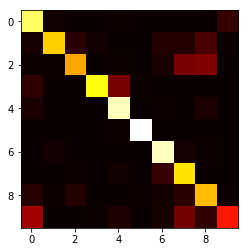

In [12]:
model = VGG16(num_classes, img_shape=IMG_SHAPE)
model.load_weights('models/checkpoints/vgg16-da-all-best/checkpoint')

y_true = []
y_pred = []
y_scores = []
for _,(X_batch, y_batch) in enumerate(val_dset.as_numpy_iterator()):
    y_true.append(y_batch)

    scores = model.predict(X_batch)
    y_scores.append(scores)
    prediction = np.argmax(scores, axis=1)
    y_pred.append(prediction)
    
y_true = np.hstack(y_true)
y_pred = np.hstack(y_pred)
y_scores = np.concatenate(y_scores)

# Log Loss Score
log_loss = metrics.log_loss(y_true, y_scores, scores_in_prob=True)
print(f"Log Loss: {log_loss}")

# Validation Accuracy
val_acc = metrics.accuracy(y_true, y_pred)
print(f"Val Accuracy: {val_acc}")

# Confusion Matrix
conf_matrix = metrics.confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Heatmap of the confusion matrix
print("Confusion Matrix Heatmap:")
plt.imshow(conf_matrix, cmap='hot', interpolation='nearest')
plt.show()